# MAXCUT Landscape Analysis

### Initial Setup
In this notebook, we start by importing necessary libraries. We use `numpy` for numerical operations, `matplotlib.pyplot` for plotting, and various components from `qiskit` to build and simulate quantum circuits. The `QAOA` from `qiskit.algorithms` is specifically used for implementing the Quantum Approximate Optimization Algorithm.


In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, Aer, execute
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import QAOA
from qiskit.utils import QuantumInstance
from qiskit_optimization.applications import Maxcut
from qiskit.opflow import AerPauliExpectation, PauliSumOp
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter

# Set a global style
plt.style.use('ggplot')

### Defining the Adjacency Matrix
The Max-Cut problem is represented using an adjacency matrix \$A\$. This matrix represents the graph where each element \$A_{ij}\$ is 1 if there is an edge between nodes \$i\$ and \$j\$, and 0 otherwise. Our sample graph has 5 nodes.


In [2]:
adjacency_matrix = np.array([
    [0, 1, 1, 0, 1],
    [1, 0, 1, 0, 0],
    [1, 1, 0, 1, 0],
    [0, 0, 1, 0, 1],
    [1, 0, 0, 1, 0]
])
print(adjacency_matrix)


[[0 1 1 0 1]
 [1 0 1 0 0]
 [1 1 0 1 0]
 [0 0 1 0 1]
 [1 0 0 1 0]]


### Visualizing the Graph
To better understand the structure of the graph we are working with, let's visualize it. Each node represents a qubit, and each edge represents a connection (problem constraint) between the qubits.
`

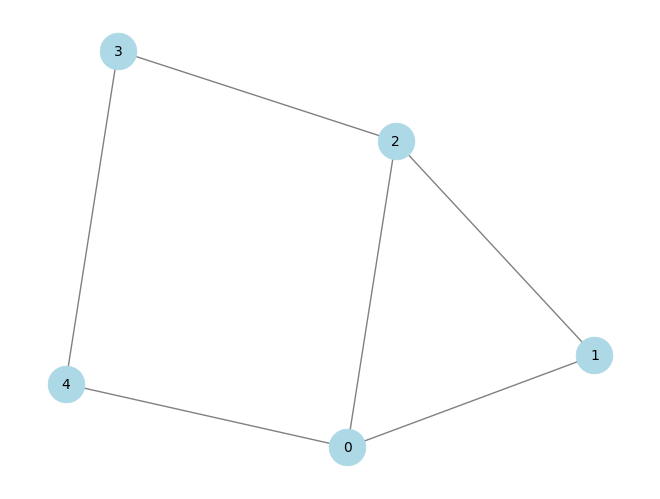

In [3]:
# Create a graph from the adjacency matrix
G = nx.from_numpy_matrix(adjacency_matrix)

# Draw the graph
pos = nx.spring_layout(G)  # Define a layout for consistent node positioning
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
plt.show()

# Regular Graphs (k-regular $k \in \{3,4 \}$)

Many papers focus largely on 3-regular or 4-regular graphs. Infact in  ["Training the Quantum Approximate Optimization Algorithm without access to a Quantum Processing Unit"](https://ar5iv.labs.arxiv.org/html/1908.08862)

They make the claim, "We might therefore find the average optimal parameters once and reuse them for all instances, thereby eliminating the computational cost per instance of finding the optimal parameters. In addition to that one can find the optimal parameters without any call to the QPU leveraging the experimental finding that the optimal parameters do not depend on the problem size."


So lets build the landscape for a problem that is $k$-regular

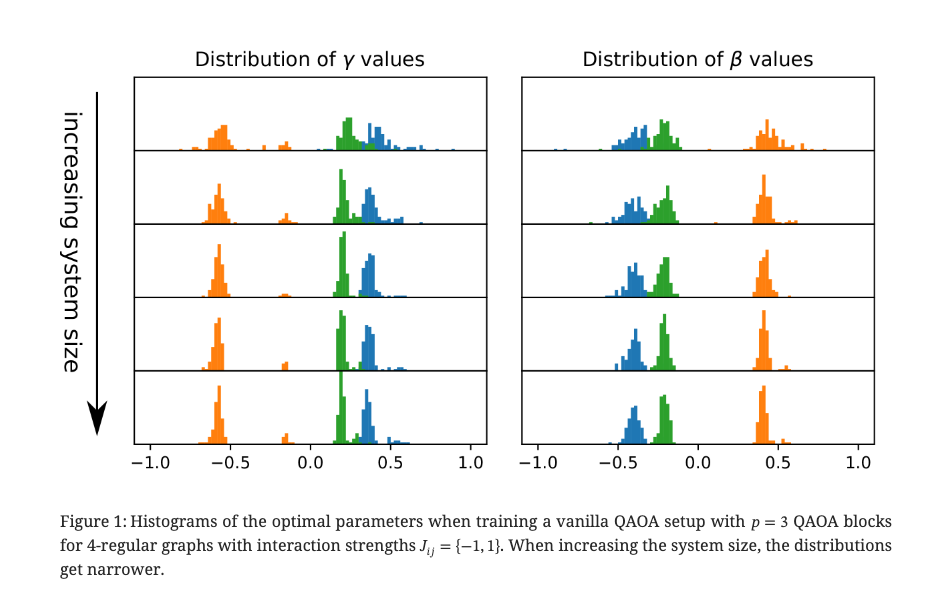

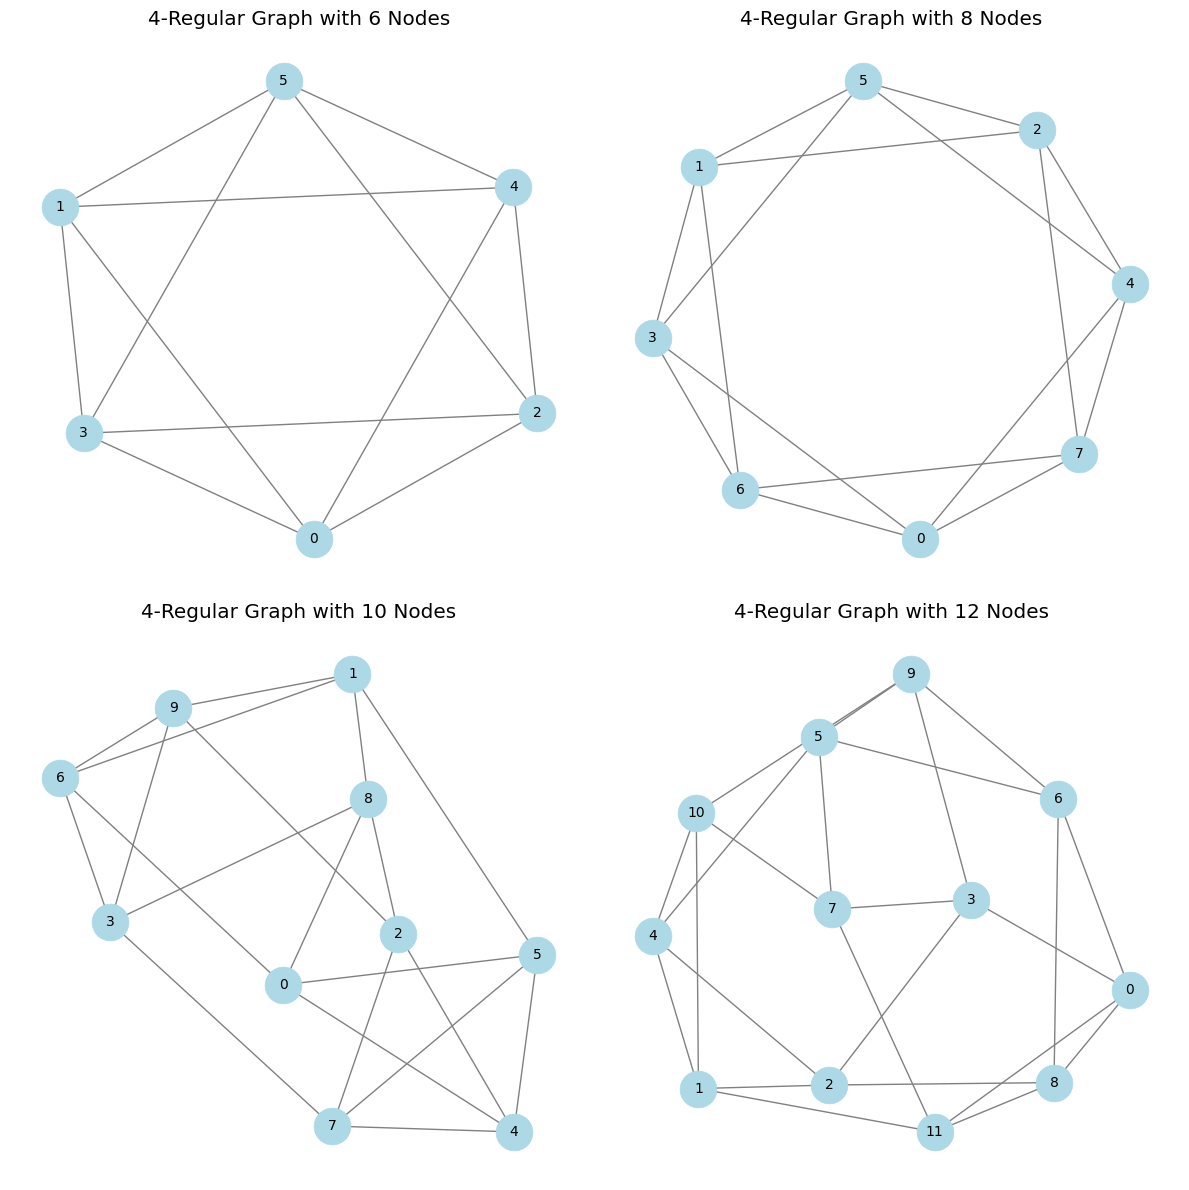

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Node sizes to generate 4-regular graphs for
node_sizes = [6, 8, 10, 12, 14]

# Setting up the plot for a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Counter for the subplot index
counter = 0
for size in node_sizes:
    if counter >= 4:  # Only plot the first four graphs
        break
    ax = axes[counter // 2, counter % 2]
    G = nx.random_regular_graph(4, size)
    pos = nx.spring_layout(G)  # Define a layout for consistent node positioning
    nx.draw(G, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
    ax.set_title(f"4-Regular Graph with {size} Nodes")
    counter += 1

plt.tight_layout()
plt.show()


### Setting up the Max-Cut Problem
Using Qiskit's `Maxcut` class, we convert our graph represented by the adjacency matrix into a problem that can be solved using a quantum algorithm. The `to_ising` method translates this problem into the Ising model, a formulation suitable for quantum optimization algorithms. In the Ising model, the goal is to minimize the Hamiltonian \$H = -\sum_{ij} A_{ij} Z_i Z_j\$, where \$Z_i\$ and \$Z_j\$ are the Pauli-Z operators on qubits \$i\$ and \$j\$.

Lets use a 6 node 4-regular graph

In [5]:
G = nx.random_regular_graph(4, 6)
# Generate the adjacency matrix
adjacency_matrix = nx.adjacency_matrix(G)
max_cut = Maxcut(adjacency_matrix)
qubitOp, offset = max_cut.to_quadratic_program().to_ising()

/var/folders/pv/xwqtt1w56s7dkzm8bn7k9gx00000gn/T/ipykernel_7455/716878234.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)


### QAOA Circuit Preparation
We initialize the QAOA circuit with a single layer (p=1). QAOA uses a combination of problem (cost) and mixer Hamiltonians, controlled by parameters \$\gamma\$ and \$\beta\$. The cost Hamiltonian encodes the problem, and the mixer Hamiltonian provides transitions between states. We use the COBYLA optimizer for the QAOA algorithm to find optimal values of \$\gamma\$ and \$\beta\$.


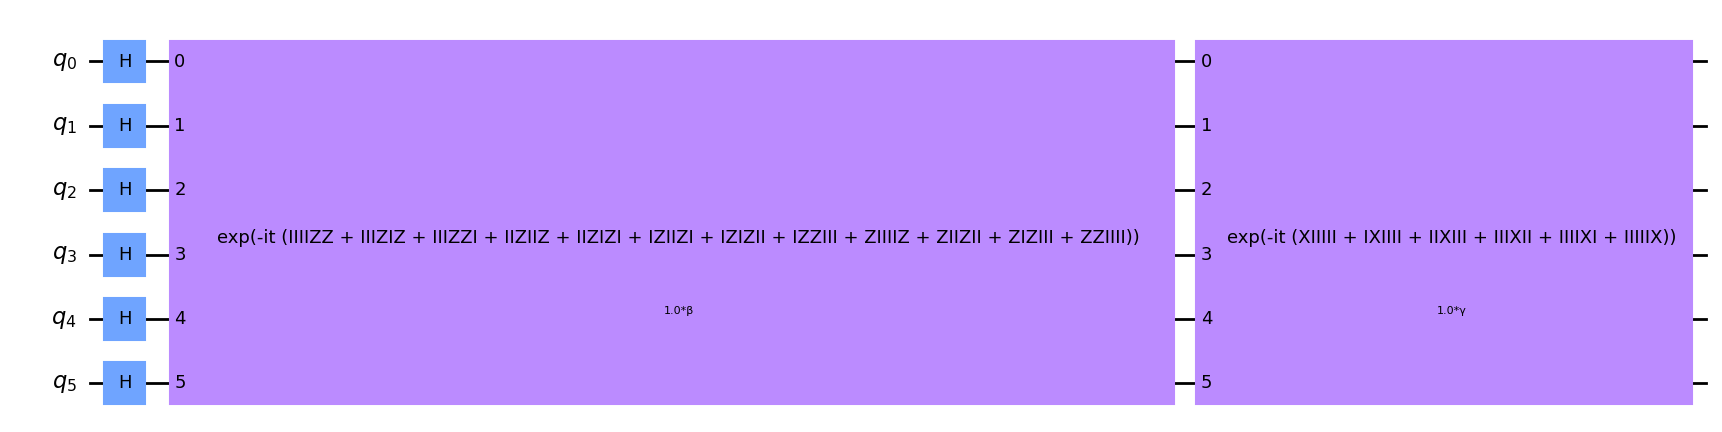

In [6]:
# Define the parameters
gamma = Parameter('γ')
beta = Parameter('β')
p=1
# Initialize the QAOA circuit with these parameters
qaoa = QAOA(optimizer=COBYLA(), reps=p, initial_point=[gamma, beta])
# Constructing the circuit with parameter objects
example_qc = qaoa.construct_circuit([gamma, beta], operator=qubitOp)[0]
# Drawing the circuit with parameter labels
example_qc.draw('mpl')

### Computing Objective Function Values
For each combination of the gamma and beta parameters, we construct the QAOA circuit and calculate the expectation value of the Hamiltonian \$\langle H \rangle\$. This step is crucial in evaluating the performance of our QAOA circuit for different parameter values, guiding us towards the optimal solution.


In [ ]:
# Initial parameters
p = 1
qaoa = QAOA(optimizer=COBYLA(), reps=p)
gamma = np.linspace(-2*np.pi, 2*np.pi, 100)
beta = np.linspace(-2*np.pi, 2*np.pi, 100)

# Compute the objective function value for each parameter combination
obj_vals = np.zeros((len(gamma), len(beta)))
for i, gamma_val in enumerate(gamma):
    for j, beta_val in enumerate(beta):
        # Bind alpha and beta parameters to the operator
        qc = qaoa.construct_circuit([gamma_val, beta_val], operator=qubitOp)[0]
        # Evaluate Backend
        backend = Aer.get_backend('aer_simulator')
        statevector = Statevector.from_instruction(qc)
        # Use the Operator class to compute the expectation value of the Hamiltonian
        expectation =  statevector.expectation_value(qubitOp).real
        obj_vals[i,j] = expectation

### Plotting the Parameter Landscape
The heatmap below represents the landscape of the objective function across different values of \$\gamma\$ and \$\beta\$. The color intensity indicates the expectation value of the Hamiltonian, helping identify the regions where optimal parameters may lie.


In [ ]:
# Plot the parameter landscape as a heatmap
plt.imshow(obj_vals.T, origin='lower', cmap='hot', extent=(-2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi))
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.title('Parameter landscape for 1-layer QAOA MAXCUT of a 4 Regular graph')
plt.colorbar()
plt.show()

In [ ]:
import plotly.graph_objs as go
# Create the Plotly figure
fig = go.Figure(data=[go.Surface(x=gamma, y=beta, z=obj_vals, colorscale='hot')])

# Set the layout and axes labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  width=700, height=700, margin=dict(l=65, r=50, b=65, t=90))

# Show the figure
fig.show()

### Brute Force Solution for the Max-Cut Problem
A brute-force solution to the Max-Cut problem involves evaluating every possible partition of the graph's nodes into two sets. We calculate the 'cut' for each partition, which is the number of edges between the two sets. The goal is to maximize this cut. This method is computationally intensive and not practical for large graphs, but it gives an exact solution for smaller ones.

In [ ]:
from itertools import combinations

def compute_max_cut_brute_force(G):
    nodes = G.nodes()
    n = len(nodes)
    max_cut_value = 0
    max_cut_partition = None

    # Iterate over all possible ways to split the nodes into two sets
    for size in range(1, n // 2 + 1):
        for subset in combinations(nodes, size):
            cut_value = sum((G.has_edge(i, j) for i in subset for j in G.nodes() if j not in subset))
            if cut_value > max_cut_value:
                max_cut_value = cut_value
                max_cut_partition = subset

    return max_cut_partition, max_cut_value

# Apply the brute force solution to our graph
max_cut_partition, max_cut_value = compute_max_cut_brute_force(G)

### Visualizing the Brute Force Solution
The solution obtained from the brute force method is visualized on the graph. Nodes are colored based on the partition they belong to in the solution that maximizes the Max-Cut. This visualization gives a clear picture of the optimal partitioning of the graph.


In [ ]:
# Define the colors for each node based on the brute force solution partition
node_colors = ['red' if node in max_cut_partition else 'blue' for node in G.nodes()]

# Draw the graph with nodes colored based on the solution
nx.draw(G, with_labels=True, node_color=node_colors, edge_color='gray', node_size=700, font_size=10)
plt.show()

# Create Results from Paper

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def create_4_regular_graph(n):
    """Creates and plots a 4-regular graph with n nodes."""
    G = nx.random_regular_graph(4, n)
    nx.draw(G, with_labels=True,node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
    plt.title(f"4-Regular Graph with {n} Nodes")
    plt.show()

# Node sizes to generate 4-regular graphs for
node_sizes = [6, 8, 10, 12, 14]

# Generate and plot the graphs
for size in node_sizes:
    create_4_regular_graph(size)


In [ ]:
import scipy
scipy.__version__